## License 

Copyright 2020 - 2023 Patrick Hall (jphall@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**DISCLAIMER:** This notebook is not legal compliance advice.

***

# Lecture 1: Building from Penalized GLM to Monotonic GBM
This example notebook proposes a methodology by which practitioners can deliberately build from simpler GLMs to more complex GBM models, by preserving maximum transparency at every step of the training process. This methodology stands in contrast to the norm of dumping wide heterogeneous training data into black-box training algorithms and selecting a model based solely on validation or test set accuracy.

#### Global hyperpameters

In [1]:
SEED                    = 12345   # global random seed for better reproducibility
GLM_SELECTION_THRESHOLD = 0.001   # threshold above which a GLM coefficient is considered "selected"

#### Python imports and inits

In [2]:
from rmltk import explain, evaluate, model                        # simple module for training, explaining, and eval
import h2o                                                        # import h2o python bindings to h2o java server
import numpy as np                                                # array, vector, matrix calculations
import operator                                                   # for sorting dictionaries
import pandas as pd                                               # DataFrame handling
import time                                                       # for timers

import matplotlib.pyplot as plt      # plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# enables display of plots in notebook
%matplotlib inline

np.random.seed(SEED)                     # set random seed for better reproducibility

h2o.init(max_mem_size='24G', nthreads=4) # start h2o with plenty of memory and threads
h2o.remove_all()                         # clears h2o memory
h2o.no_progress()                        # turn off h2o progress indicators    

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,28 mins 56 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.3
H2O cluster version age:,9 months and 1 day !!!
H2O cluster name:,H2O_from_python_patrickh_dg5v7h
H2O cluster total nodes:,1
H2O cluster free memory:,20.83 Gb
H2O cluster total cores:,24
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


#### Start global timer

In [3]:
big_tic = time.time()

## 1. Download, Explore, and Prepare UCI Credit Card Default Data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input features: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

The steps below build several models to predict `DEFAULT_NEXT_MONTH` using payment, billing, and credit limit information in the UCI credit card default data.

#### Import data and reformat

In [4]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1) # skip the first row of the spreadsheet

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles
Notice that demographic features are not used as model inputs.

In [5]:
# assign target and inputs for models
y_name = 'DEFAULT_NEXT_MONTH'
x_names = [name for name in data.columns if name not in [y_name, 'ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']]
print('y_name =', y_name)
print('x_names =', x_names)

y_name = DEFAULT_NEXT_MONTH
x_names = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Display descriptive statistics

In [6]:
data[x_names + [y_name]].describe() 

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## 2. Investigate Pair-wise Pearson Correlations for `DEFAULT_NEXT_MONTH`
One of the simplest and most direct ways to understand relationships between input features and the prediction target, `DEFAULT_NEXT_MONTH`, is Pearson correlation. In this notebook, Pearson correlation serves as a baseline understanding against which to consider more complex models.

#### Calculate Pearson correlation

In [7]:
# Pearson correlation between inputs and target
# is last column of correlation matrix
corr = pd.DataFrame(data[x_names + [y_name]].corr()[y_name]).iloc[:-1]
corr.columns = ['Pearson Correlation Coefficient']
corr

,Pearson Correlation Coefficient
LIMIT_BAL,-0.153520
PAY_0,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149
PAY_6,0.186866
BILL_AMT1,-0.019644
BILL_AMT2,-0.014193
BILL_AMT3,-0.014076


#### Plot Pearson correlation

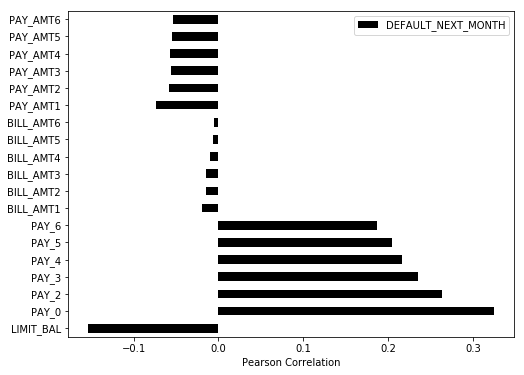

In [8]:
# display correlation to target as barchart
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = pd.DataFrame(data[x_names + [y_name]].corr()[y_name]).iloc[:-1].plot(kind='barh', ax=ax_, colormap='gnuplot')
_ = ax_.set_xlabel('Pearson Correlation')

This plot of Pearson correlation shows that the `PAY_*` payment status features are the most correlated to `DEFAULT_NEXT_MONTH`. The `PAY_*` features are positively correlated with `DEFAULT_NEXT_MONTH`, with most recent repayment status, `PAY_0`, being the most correlated, and subsequent repayment statuses being less correlated over time. This means that as `PAY_*` features increase in value under a more complex model, the predicted probability of default or `p_DEFAULT_NEXT_MONTH`, should likely be expected to increase as well. All the other input features are negatively correlated with `DEFAULT_NEXT_MONTH`, meaning as their values increase, `p_DEFAULT_NEXT_MONTH` should probably be expected to decrease under a more complex model. `LIMIT_BAL` appears to be the most negatively correlated, followed by the `PAY_AMT*` features, and then the `BILL_AMT*` features. The `PAY_AMT*` and `BILL_AMT*` features show the same pattern of decreasing importance over time as the `PAY_*` payment status features. 

It is reasonable to expect a more complex model to reflect many of these findings.

## 3. Train Elastic Net Logistic GLM for Initial Feature Selection 
Elastic net penalized regression is a linear modeling technique that uses L2 regularization and (often) the IRLS optimization approach to be more robust to correlation and outliers than traditional OLS regression methods. It is also able to use L1 regularization to select features without the potentially problematic multiple hypotheses testing found in forward and backward selection methods. Elastic net regression does not produce *t*-statistic and *p*-values like OLS regression methods, but the model coefficients have roughly the same interpretation as the more traditional approach. 

Elastic net regression will serve as the next step beyond Pearson correlation to model `DEFAULT_NEXT_MONTH`. Because of its robustness and interpretability, elastic net regression is often a good choice for a benchmark model from which to construct more complex models.

### 3.1 Elastic Net Forward Step-wise Training

#### Split data into training and validation partitions
Most elastic net approaches require validation for hyperparameter tuning.

In [9]:
split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 20946, columns = 25
Validation data rows = 9054, columns = 25


#### Train penalized GLM for initial benchmark and feature selection 
The `glm_grid()` function below automatically searches over elastic net hyperparameters to find the best penalized linear model for a dataset. 

In [10]:
# train penalized GLM w/ alpha and lambda grid search
best_glm = model.glm_grid(x_names, y_name, h2o.H2OFrame(train),
                          h2o.H2OFrame(valid), SEED)

# output results
print('Best penalized GLM AUC: %.2f' % 
      best_glm.auc(valid=True))

# print selected coefficients
print('Best penalized GLM coefficients:')
for c_name, c_val in sorted(best_glm.coef().items(), key=operator.itemgetter(1)):
    if abs(c_val) > GLM_SELECTION_THRESHOLD:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))

Best penalized GLM AUC: 0.73
Best penalized GLM coefficients:
Intercept:                -1.0553055885519234
PAY_6:                    0.012282515281903404
PAY_4:                    0.02548663430338296
PAY_5:                    0.04613937054483111
PAY_3:                    0.07909158701433701
PAY_2:                    0.08471364623597981
PAY_0:                    0.5371954715199951


The penalized GLM selects the six `PAY_*` repayment status features to predict `p_DEFAULT_NEXT_MONTH`. The coefficient for, say `PAY_0`, can be interpreted as: holding all other features constant, for a 1-unit change in most recent repayment status (`PAY_0`), the odds of a customer defaulting next month (`DEFAULT_NEXT_MONTH`) change by a factor of 1.71 (*e*<sup>0.537</sup>). The penalized GLM has an adequate `AUC` of 0.73, meaning that the probability the penalized GLM ranks a discordant pair of customers (customer 1 `DEFAULT_NEXT_MONTH=0`, customer 2 `DEFAULT_NEXT_MONTH=1`) correctly is 0.73.

### 3.2 Model Details for Model Documentation
It is generally important to document all details of a model in case something goes wrong with the model in the future and someone needs to investigate what happened. 

#### Display best GLM information

In [11]:
best_glm 

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_Key_Frame__upload_8080b3352814b923e304e74d95f84351.hex_model_python_1590421507722_28818_model_1


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.01, lambda = 0.005908 )","nlambda = 100, lambda.max = 13.333, lambda.min = 0.005908, lambda....",19,19,109,Key_Frame__upload_8080b3352814b923e304e74d95f84351.hex




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.14649158915954694
RMSE: 0.3827421967324049
LogLoss: 0.4685812636002607
Null degrees of freedom: 20945
Residual degrees of freedom: 20926
Null deviance: 22178.75361964548
Residual deviance: 19629.80629474212
AIC: 19669.80629474212
AUC: 0.7182752479663853
pr_auc: 0.5010322496049208
Gini: 0.4365504959327706

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2498310673824375: 

,,0,1,Error,Rate
0,0,13778.0,2518.0,0.1545,(2518.0/16296.0)
1,1,2168.0,2482.0,0.4662,(2168.0/4650.0)
2,Total,15946.0,5000.0,0.2237,(4686.0/20946.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.249831,0.514404,205.0
1,max f2,0.054654,0.594059,377.0
2,max f0point5,0.399178,0.567555,137.0
3,max accuracy,0.418922,0.817053,128.0
4,max precision,0.706802,0.797414,34.0
5,max recall,0.001281,1.000000,399.0
6,max specificity,0.989212,0.999570,0.0
7,max absolute_mcc,0.399178,0.396395,137.0
8,max min_per_class_accuracy,0.221641,0.658925,237.0
9,max mean_per_class_accuracy,0.245211,0.690483,210.0



Gains/Lift Table: Avg response rate: 22.20 %, avg score: 22.20 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010026,7.192943e-01,3.539263,3.539263,0.785714,0.816889,0.785714,0.816889,0.035484,0.035484,253.926267,253.926267
1,,2,0.020004,6.109553e-01,2.952721,3.246692,0.655502,0.659815,0.720764,0.738540,0.029462,0.064946,195.272110,224.669182
2,,3,0.030030,5.904669e-01,3.303312,3.265595,0.733333,0.600522,0.724960,0.692461,0.033118,0.098065,230.331183,226.559516
3,,4,0.040008,5.652261e-01,3.469986,3.316571,0.770335,0.576997,0.736277,0.663664,0.034624,0.132688,246.998611,231.657094
4,,5,0.050033,5.378222e-01,3.024461,3.258037,0.671429,0.552092,0.723282,0.641307,0.030323,0.163011,202.446083,225.803743
5,,6,0.100019,4.442181e-01,2.916965,3.087582,0.647564,0.484561,0.685442,0.562971,0.145806,0.308817,191.696460,208.758242
6,,7,0.150005,3.537487e-01,2.090922,2.755468,0.464183,0.405265,0.611712,0.510419,0.104516,0.413333,109.092153,175.546785
7,,8,0.200038,2.655100e-01,1.427003,2.423193,0.316794,0.294731,0.537947,0.456471,0.071398,0.484731,42.700320,142.319316
8,,9,0.300010,2.382281e-01,1.015345,1.954060,0.225406,0.248630,0.433800,0.387213,0.101505,0.586237,1.534461,95.405967
9,,10,0.400029,2.224902e-01,0.672990,1.633754,0.149403,0.229921,0.362692,0.347885,0.067312,0.653548,-32.701024,63.375397




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.14363466020798762
RMSE: 0.3789916360660056
LogLoss: 0.4617337838828072
Null degrees of freedom: 9053
Residual degrees of freedom: 9034
Null deviance: 9526.71172610569
Residual deviance: 8361.075358549871
AIC: 8401.075358549871
AUC: 0.7303402396287311
pr_auc: 0.5061676572465437
Gini: 0.46068047925746214

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26072851982555734: 

,,0,1,Error,Rate
0,0,6083.0,985.0,0.1394,(985.0/7068.0)
1,1,921.0,1065.0,0.4637,(921.0/1986.0)
2,Total,7004.0,2050.0,0.2105,(1906.0/9054.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.260729,0.527750,193.0
1,max f2,0.116430,0.592436,329.0
2,max f0point5,0.400670,0.576923,134.0
3,max accuracy,0.433434,0.822288,120.0
4,max precision,0.572358,0.743386,68.0
5,max recall,0.007410,1.000000,397.0
6,max specificity,0.989045,0.999859,0.0
7,max absolute_mcc,0.370892,0.413902,147.0
8,max min_per_class_accuracy,0.225699,0.672205,230.0
9,max mean_per_class_accuracy,0.246401,0.699498,206.0



Gains/Lift Table: Avg response rate: 21.94 %, avg score: 22.66 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010051,7.207631e-01,3.106072,3.106072,0.681319,0.813734,0.681319,0.813734,0.031219,0.031219,210.607218,210.607218
1,,2,0.020102,6.229843e-01,3.156170,3.131121,0.692308,0.663736,0.686813,0.738735,0.031722,0.062941,215.617011,213.112114
2,,3,0.030042,5.993452e-01,3.545821,3.268338,0.777778,0.607299,0.716912,0.695245,0.035247,0.098187,254.582075,226.833792
3,,4,0.040093,5.753741e-01,3.757345,3.390927,0.824176,0.587697,0.743802,0.668284,0.037764,0.135952,275.734537,239.092657
4,,5,0.050033,5.509826e-01,3.241893,3.361317,0.711111,0.562950,0.737307,0.647357,0.032226,0.168177,224.189325,236.131730
5,,6,0.100066,4.545088e-01,2.968828,3.165073,0.651214,0.496126,0.694260,0.571741,0.148540,0.316717,196.882815,216.507273
6,,7,0.149989,3.741888e-01,2.208854,2.846802,0.484513,0.414835,0.624448,0.519516,0.110272,0.426989,120.885357,184.680243
7,,8,0.200022,2.740947e-01,1.489446,2.507276,0.326711,0.315894,0.549972,0.468582,0.074522,0.501511,48.944599,150.727595
8,,9,0.299978,2.407348e-01,0.997420,2.004176,0.218785,0.253042,0.439617,0.396762,0.099698,0.601208,-0.258049,100.417577
9,,10,0.400044,2.249573e-01,0.719563,1.682845,0.157837,0.232429,0.369133,0.355656,0.072004,0.673212,-28.043657,68.284535




Scoring History: 

,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
0,,2020-05-25 12:14:06,0.000 sec,1,.13E2,1,1.058854,1.052210
1,,2020-05-25 12:14:06,0.016 sec,2,.12E2,2,1.058595,1.051942
2,,2020-05-25 12:14:06,0.031 sec,3,.11E2,2,1.058312,1.051649
3,,2020-05-25 12:14:06,0.047 sec,4,.1E2,3,1.057846,1.051165
4,,2020-05-25 12:14:06,0.064 sec,5,.92E1,4,1.057200,1.050494
5,,2020-05-25 12:14:06,0.081 sec,6,.84E1,5,1.056328,1.049589
6,,2020-05-25 12:14:06,0.092 sec,7,.76E1,6,1.055193,1.048412
7,,2020-05-25 12:14:06,0.106 sec,8,.7E1,7,1.053849,1.047023
8,,2020-05-25 12:14:06,0.123 sec,9,.63E1,7,1.052407,1.045532
9,,2020-05-25 12:14:06,0.135 sec,10,.58E1,8,1.050810,1.043879



See the whole table with table.as_data_frame()


#### Plot penalized GLM coefficient regularization path
One kind of information someone might be interested in for elastic net GLM is the regularization path for the model coefficients. The plot below shows how the training process treated each `PAY_*` feature during the training process.

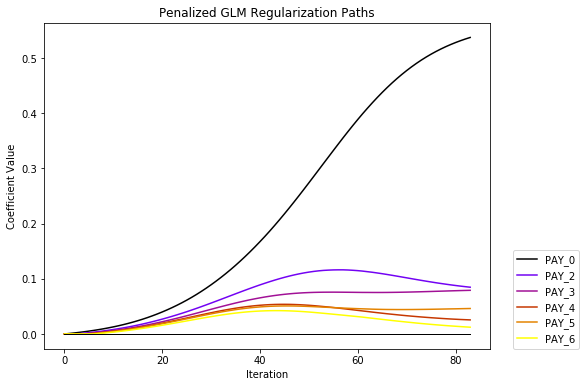

In [12]:
# collect regularization paths from dict in DataFrame
reg_path_dict = best_glm.getGLMRegularizationPath(best_glm)
reg_path_frame = pd.DataFrame(columns=reg_path_dict['coefficients'][0].keys())
for i in range(0, len(reg_path_dict['coefficients'])): 
    reg_path_frame = reg_path_frame.append(reg_path_dict['coefficients'][i], 
                                           ignore_index=True)

    
# establish benchmark feature selection: glm_selected 
glm_selected = list(reg_path_frame.iloc[-1, :][reg_path_frame.iloc[-1, :] > GLM_SELECTION_THRESHOLD].index)

# plot regularization paths
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = reg_path_frame[glm_selected].plot(kind='line', ax=ax_, title='Penalized GLM Regularization Paths',
                                      colormap='gnuplot')
_ = ax_.set_xlabel('Iteration')
_ = ax_.set_ylabel('Coefficient Value')
_ = ax_.axhline(c='k', lw=1, xmin=0.045, xmax=0.955)
_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

### 3.3 Compare Global Model Weights Against Alternative Model

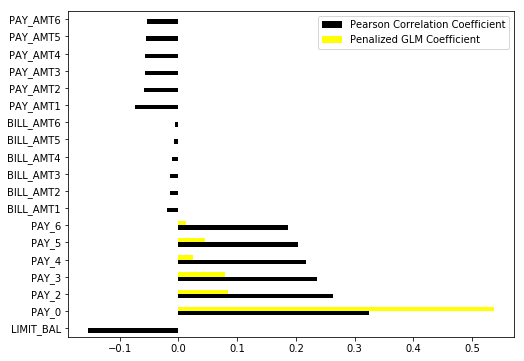

In [13]:
# collect Pearson correlation and GLM coefficients into same DataFrame
glm_selected_coef = pd.DataFrame.from_dict(best_glm.coef(), orient='index', columns=['Penalized GLM Coefficient'])
corr_glm = pd.concat([corr, glm_selected_coef.iloc[1:]], axis=1)

# plot
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = corr_glm.plot(kind='barh', ax=ax_, colormap='gnuplot')

As compared to Pearson correlation, the penalized GLM does select the 6 features that are most positively correlated to `DEFAULT_NEXT_MONTH`. However, it does not select any of the negatively correlated features and it gives extremely high weight to `PAY_0` and weighs `PAY_5` out of order in time.

### 3.4 Partial Dependence and ICE for Model Documentation
Plots of partial dependence display the estimated average behavior of a predictive model across the domain of an input feature. ICE plots show how certain individuals behave under a model. Pairing partial dependence and ICE together provides a nice portrait of the behavior of a feature under a model on average and for some individuals.

#### Calculate partial dependence for each feature in best GLM

In [14]:
# init dict to hold partial dependence and ICE values
# for each feature
# for glm
glm_pd_ice_dict = {}

# calculate partial dependence for each selected feature
for xs in glm_selected: 
    glm_pd_ice_dict[xs] = explain.pd_ice(xs, valid, best_glm)

#### Find some percentiles of yhat in the validation data
ICE can be plotted for just one or many individuals. Since no particular individual is interesting, yet, under the penalized GLM, individuals at deciles of `p_DEFAULT_NEXT_MONTH` are selected for ICE.

In [15]:
# merge GLM predictions onto test data
glm_yhat_valid = pd.concat([valid.reset_index(drop=True),
                            best_glm.predict(h2o.H2OFrame(valid))['p1'].as_data_frame()],
                           axis=1)

# rename yhat column
glm_yhat_valid = glm_yhat_valid.rename(columns={'p1':'p_DEFAULT_NEXT_MONTH'})

# find percentiles of predictions
glm_percentile_dict = explain.get_percentile_dict('p_DEFAULT_NEXT_MONTH', glm_yhat_valid, 'ID')

# display percentiles dictionary
# key=percentile, val=row_id
glm_percentile_dict

{0: 28717,
 99: 13713,
 10: 27519,
 20: 29714,
 30: 1012,
 40: 12100,
 50: 2849,
 60: 3518,
 70: 26302,
 80: 5763,
 90: 7083}

#### Calculate ICE curve values

In [16]:
# loop through selected features
for xs in glm_selected: 

    # collect bins used in partial dependence
    bins = list(glm_pd_ice_dict[xs][xs])
    
    # calculate ICE at percentiles 
    # using partial dependence bins
    # for each selected feature
    for i in sorted(glm_percentile_dict.keys()):
        col_name = 'Percentile_' + str(i)
        glm_pd_ice_dict[xs][col_name] = explain.pd_ice(xs, # x_names used here b/c all features have small coef in GLM
                                                       valid[valid['ID'] == int(glm_percentile_dict[i])][x_names], 
                                                       best_glm, 
                                                       bins=bins)['partial_dependence']
       

#### Assess partial dependence and ICE for each feature in best GLM
In addition to displaying partial dependence and ICE plots below, a histogram of the feature of interest is also displayed. The histogram helps uncover issues related to data sparsity, i.e., in the areas of an input feature's domain where there is little or no training data, the model's predictions are generally less trustworthy. The histograms below also include an overlay of the average value of `DEFAULT_NEXT_MONTH`. This overlay gives some understanding of what partial dependence and ICE curves should look like.

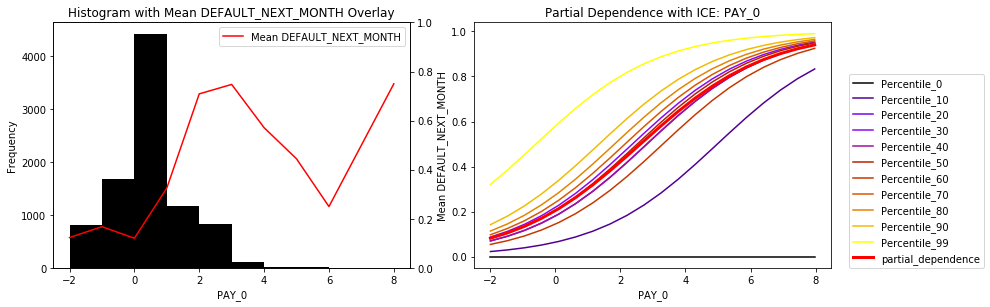

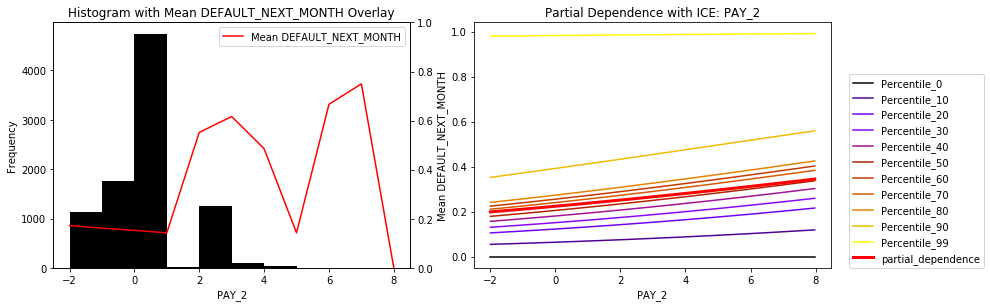

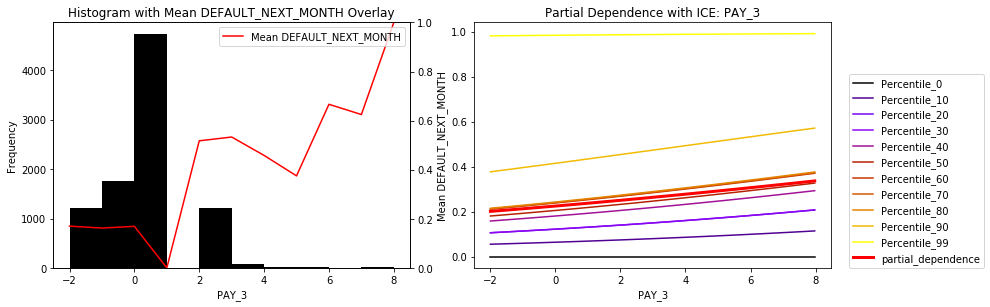

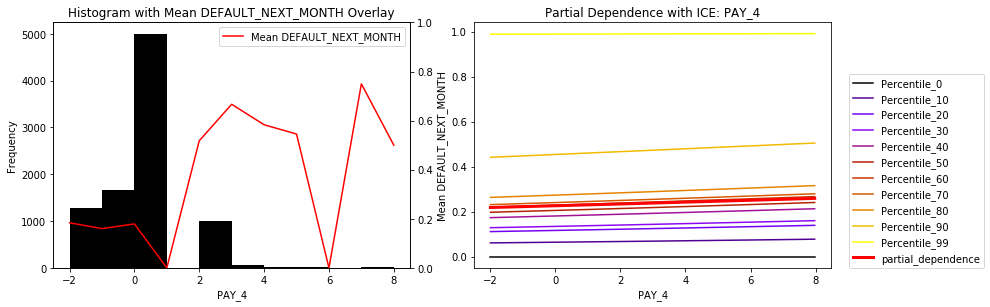

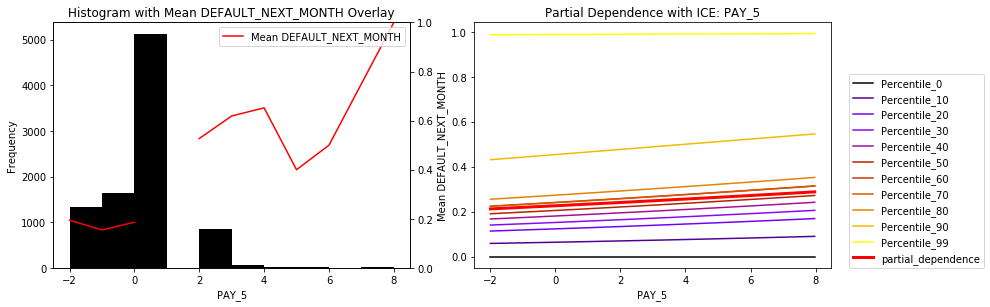

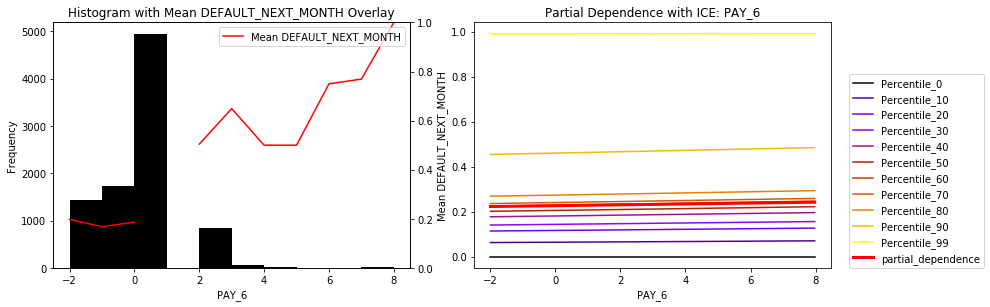

In [17]:
for xs in glm_selected: 
    explain.hist_mean_pd_ice_plot(xs, y_name, valid, glm_pd_ice_dict)

The plots above show the expected logistic behavior for each input feature, with `PAY_0` showing the steepest partial dependence and ICE curves. Aside from the high-degree of importance placed on `PAY_0`, these plots are aligned with the small Pearson correlations for the remaining `PAY_*` features. Histograms do display some data sparsity problems for customers with late payments and mean `DEFAULT_NEXT_MONTH` overlays do show some nonlinear swings in average `DEFAULT_NEXT_MONTH` values, but the logistic form of the model prevents it from overfitting noise in the sparse areas. The monotonic logistic model also does not allow for fitting to the potentially non-monotonic average behavior of  `DEFAULT_NEXT_MONTH`. Below, these plots will allow for the comparison of the penalized GLM to a monotonic GBM model on a per-feature basis.

## 4. Train Monotonic GBM with Forward Feature Selection
The next step in complexity from the penalized GLM will be a monotonically constrained GBM model. The GBM model can fit the data using arbitrarily complex stair-step patterns, as opposed to being locked into the logistic function form. The goal is to compare the behavior of the monotonic GBM to the penalized GLM and Pearson correlation coefficients to make sure we trust and understand what the monotonic GBM is doing. 

### 4.1 Forward Step-wise Training
The monotonic GBM will start with the 6 `PAY_*` features selected by the GLM, then try adding in the next most correlated feature to the model. Monotone constraints for each feature are also set by the sign of the Pearson correlation between an input feature and `DEFAULT_NEXT_MONTH`. Each new set of training features is run through a random grid search to make sure a somewhat stable and accurate GBM is trained during each forward selection step. 

In [18]:
# initialize data structures needed to compare correlation coefficients,
# penalized glm coefficients, and MGBM Shapley values
# as features are added into the MGBM
abs_corr = corr.copy(deep=True)
abs_corr['Pearson Correlation Coefficient'] = corr['Pearson Correlation Coefficient'].abs()

# create a list of features to add into MGBM
# list is ordered by correlation between X_j and y
next_list = [name for name in list(abs_corr.sort_values(by='Pearson Correlation Coefficient',
                                                        ascending=False).index) if name not in glm_selected]

# create a DataFrame to store new MGBM SHAP values
# for comparison to correlation and penalized glm coefficients
abs_corr_glm_mgbm_shap = corr_glm.copy(deep=True).abs()
abs_corr_glm_mgbm_shap.columns = ['Absolute ' + name for name in abs_corr_glm_mgbm_shap.columns]
abs_corr_glm_mgbm_shap['Monotonic GBM Mean SHAP Value'] = 0

# start local timer
tic = time.time()

# forward stepwise MGBM training
mgbm_train_results = model.gbm_forward_select_train(glm_selected, 
                                                    y_name, 
                                                    train, 
                                                    valid, 
                                                    SEED, 
                                                    next_list,
                                                    abs_corr_glm_mgbm_shap, 
                                                    'Monotonic GBM Mean SHAP Value',
                                                    monotone=True)

mgbm_models = mgbm_train_results['MODELS']
corr_glm_mgbm_shap_coefs = mgbm_train_results['GLOBAL_COEFS']
mgbm_shap = mgbm_train_results['LOCAL_COEFS']

# end local timer
toc = time.time()-tic
print('Task completed in %.2f s.' % (toc))

# 2 threads  - 695 s
# 4 threads  - 691 s
# 8 threads  - 692 s
# 24 threads - 713 s

Starting grid search 1/14 ...
Input features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
Monotone constraints = {'PAY_0': 1, 'PAY_2': 1, 'PAY_3': 1, 'PAY_4': 1, 'PAY_5': 1, 'PAY_6': 1}
Completed grid search 1/14 with AUC: 0.74 ...
--------------------------------------------------------------------------------
Starting grid search 2/14 ...
Input features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'LIMIT_BAL']
Monotone constraints = {'PAY_0': 1, 'PAY_2': 1, 'PAY_3': 1, 'PAY_4': 1, 'PAY_5': 1, 'PAY_6': 1, 'LIMIT_BAL': -1}
Completed grid search 2/14 with AUC: 0.76 ...
--------------------------------------------------------------------------------
Starting grid search 3/14 ...
Input features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'LIMIT_BAL', 'PAY_AMT1']
Monotone constraints = {'PAY_0': 1, 'PAY_2': 1, 'PAY_3': 1, 'PAY_4': 1, 'PAY_5': 1, 'PAY_6': 1, 'LIMIT_BAL': -1, 'PAY_AMT1': -1}
Completed grid search 3/14 with AUC: 0.77 ...
------------------

### 4.2 Compare Global Model Weights for Alternative Models
Shapley values, or the mean contribution of a feature beyond the average prediction, allow us to compare how the monotonic GBM weighs features as compared to the penalized GLM and the Pearson correlation coefficients. For each model, the similarities are somewhat striking given that no values were scaled. Also note that the first monotonic GBM model, trained on only the GLM features, is more accurate than the penalized GLM. This indicates the ability of the monotonic GBM to fit nonlinear stair-step patterns is likely useful and representative of the training data.

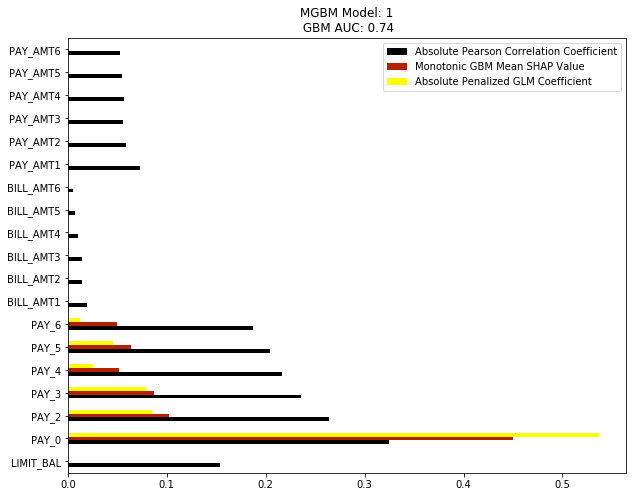

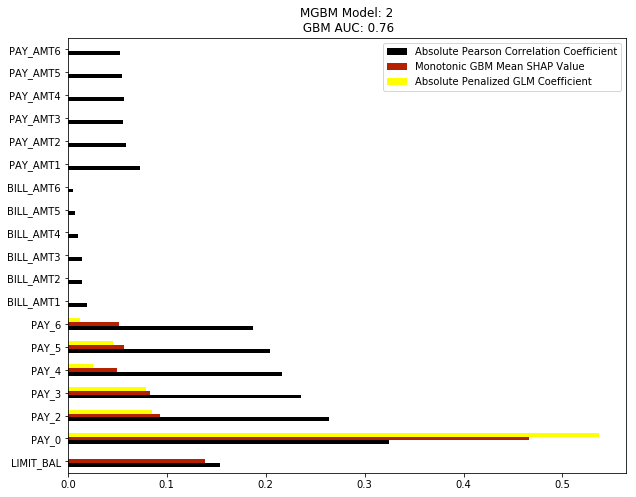

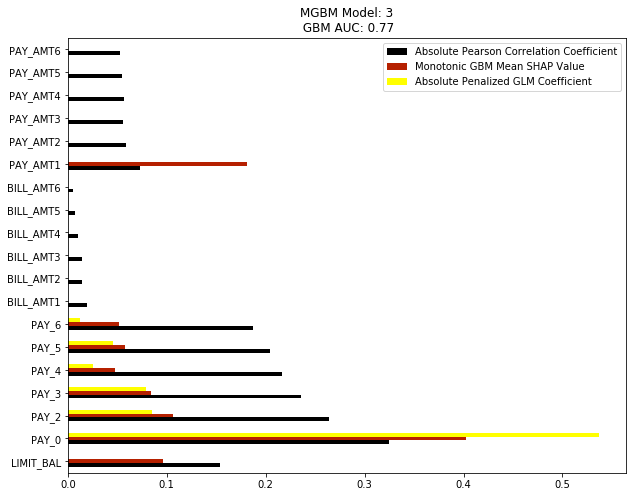

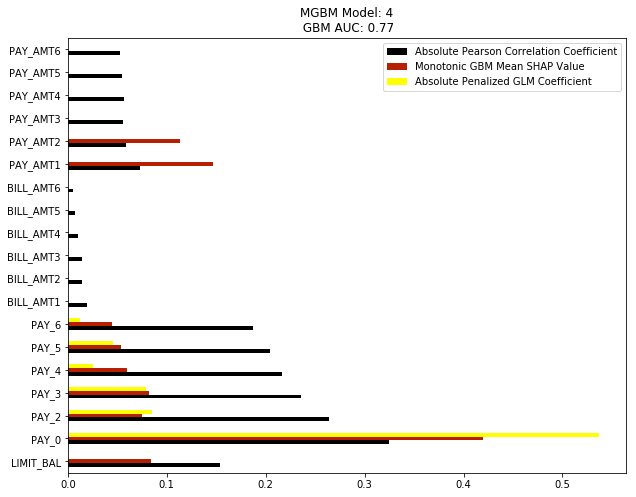

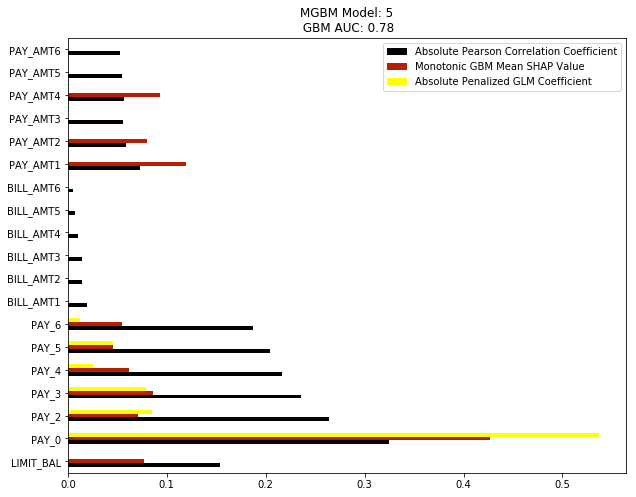

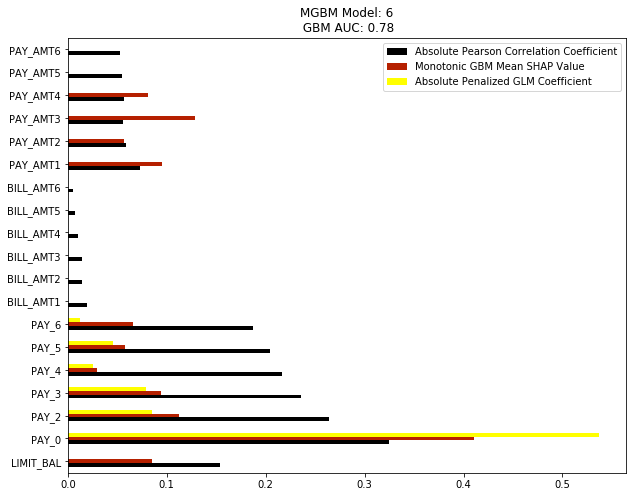

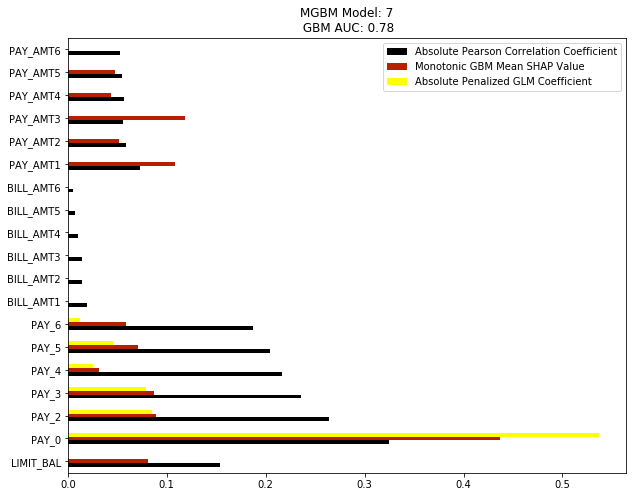

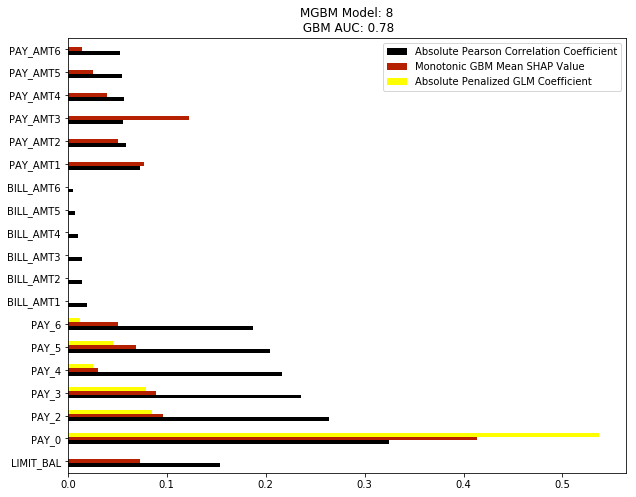

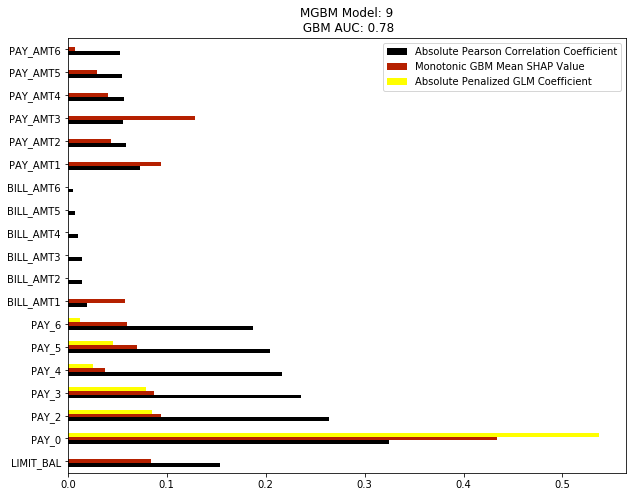

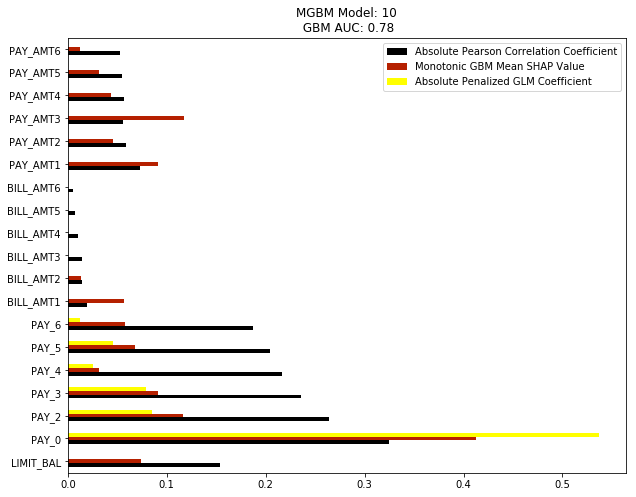

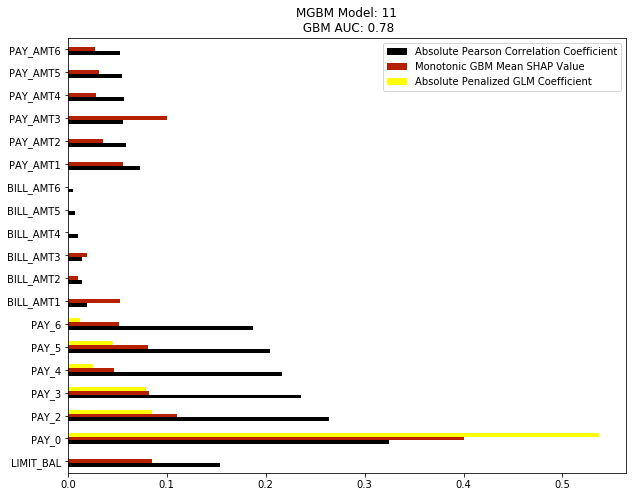

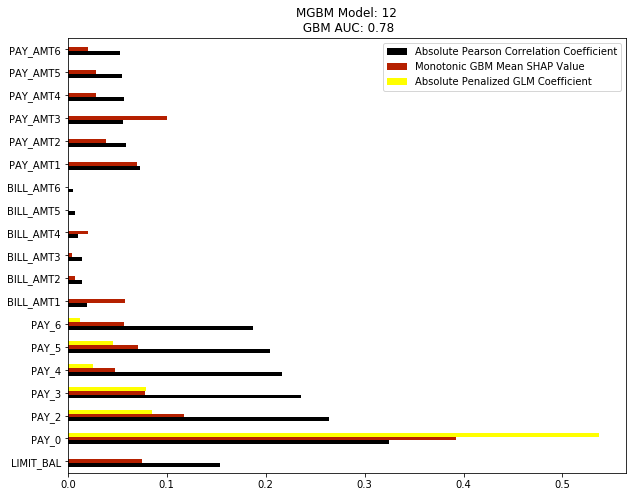

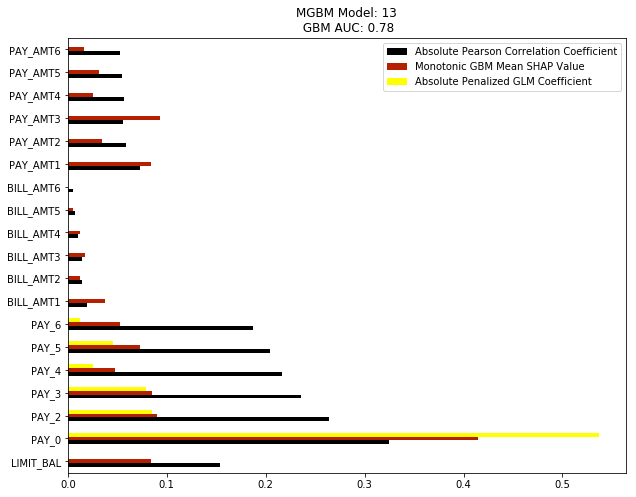

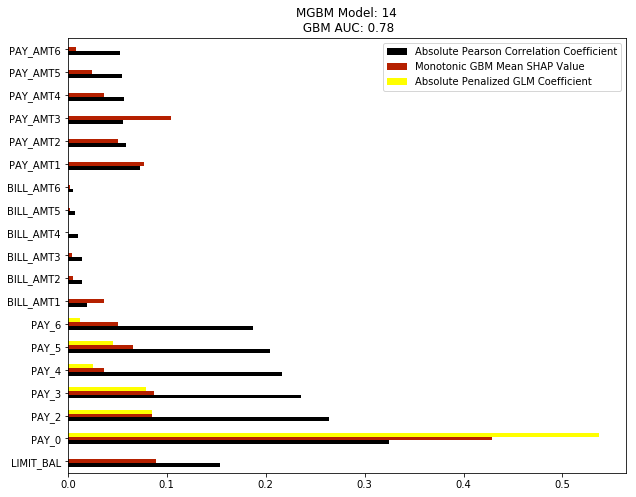

In [19]:
explain.plot_coefs(corr_glm_mgbm_shap_coefs,
                   mgbm_models, 
                   'MGBM',
                   ['Absolute Pearson Correlation Coefficient',
                    'Monotonic GBM Mean SHAP Value',
                    'Absolute Penalized GLM Coefficient'])

###  4.3 Perform Cross-validated Ranking to Select Best MGBM Against Alternative Models
For small data, selecting a best model based on a single value in a validation set can lead to silly results. Here, a combination of ranking models across many metrics and many folds is used to ensure that the simplest and most accurate model is selected.

In [20]:
# autoph cv_model_rank_select function
# requires models to have model_id 
best_glm.model_id = 'best_glm'
compare_model_ids = ['best_glm'] # list of model_ids

# start local timer
tic = time.time()

# perform CV rank model selection
mgbm_rank_results = evaluate.cv_model_rank_select(valid,
                                                  SEED,
                                                  mgbm_train_results,
                                                  'mgbm',
                                                  compare_model_ids)

best_mgbm = mgbm_rank_results['BEST_MODEL']
best_mgbm_shap = mgbm_rank_results['BEST_LOCAL_COEFS']
mgbm_selected_coefs = mgbm_rank_results['BEST_GLOBAL_COEFS']
best_mgbm_eval = mgbm_rank_results['METRICS']


# end local timer
toc = time.time()-tic
print('Task completed in %.2f s.' % (toc))

Evaluated model 1/14 with rank: 1.20* ...
Evaluated model 2/14 with rank: 1.08* ...
Evaluated model 3/14 with rank: 1.08 ...
Evaluated model 4/14 with rank: 1.04* ...
Evaluated model 5/14 with rank: 1.00* ...
Evaluated model 6/14 with rank: 1.00 ...
Evaluated model 7/14 with rank: 1.04 ...
Evaluated model 8/14 with rank: 1.06 ...
Evaluated model 9/14 with rank: 1.08 ...
Evaluated model 10/14 with rank: 1.04 ...
Evaluated model 11/14 with rank: 1.04 ...
Evaluated model 12/14 with rank: 1.04 ...
Evaluated model 13/14 with rank: 1.04 ...
Evaluated model 14/14 with rank: 1.08 ...
Done.
Task completed in 352.24 s.


### 4.4 Model Details for Model Documentation

#### Inspect best MGBM 

In [21]:
best_mgbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  mgbm5


Model Summary: 

,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,46.0,46.0,6942.0,3.0,3.0,3.0,5.0,8.0,7.369565




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13637719864300343
RMSE: 0.3692928358945018
LogLoss: 0.4351274080189972
Mean Per-Class Error: 0.2913939696264273
AUC: 0.7716491282246187
pr_auc: 0.5471826859054356
Gini: 0.5432982564492375

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21968260039166268: 

,,0,1,Error,Rate
0,0,13482.0,2814.0,0.1727,(2814.0/16296.0)
1,1,1907.0,2743.0,0.4101,(1907.0/4650.0)
2,Total,15389.0,5557.0,0.2254,(4721.0/20946.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.219683,0.537474,248.0
1,max f2,0.127859,0.630227,329.0
2,max f0point5,0.446699,0.583033,147.0
3,max accuracy,0.446699,0.821493,147.0
4,max precision,0.950247,1.000000,0.0
5,max recall,0.050609,1.000000,395.0
6,max specificity,0.950247,1.000000,0.0
7,max absolute_mcc,0.325159,0.413494,194.0
8,max min_per_class_accuracy,0.177542,0.698495,281.0
9,max mean_per_class_accuracy,0.219683,0.708606,248.0



Gains/Lift Table: Avg response rate: 22.20 %, avg score: 22.00 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010074,0.813927,3.607883,3.607883,0.800948,0.843446,0.800948,0.843446,0.036344,0.036344,260.788259,260.788259
1,,2,0.020338,0.795575,3.519808,3.563432,0.781395,0.805153,0.791080,0.824119,0.036129,0.072473,251.980795,256.343177
2,,3,0.030316,0.763679,3.405328,3.511394,0.755981,0.783970,0.779528,0.810905,0.033978,0.106452,240.532798,251.139446
3,,4,0.040008,0.715138,3.261891,3.450954,0.724138,0.739815,0.766110,0.793684,0.031613,0.138065,226.189099,245.095388
4,,5,0.050081,0.664416,3.116869,3.383755,0.691943,0.686695,0.751192,0.772164,0.031398,0.169462,211.686898,238.375473
5,,6,0.100019,0.543384,2.859463,3.121984,0.634799,0.601794,0.693079,0.687101,0.142796,0.312258,185.946339,212.198445
6,,7,0.150005,0.366237,2.224293,2.822849,0.493792,0.446951,0.626671,0.607076,0.111183,0.423441,122.429306,182.284922
7,,8,0.205672,0.292765,1.595510,2.490659,0.354202,0.312777,0.552925,0.527422,0.088817,0.512258,59.551043,149.065864
8,,9,0.301251,0.196648,1.174504,2.073077,0.260739,0.234499,0.460222,0.434485,0.112258,0.624516,17.450421,107.307684
9,,10,0.400029,0.173817,0.864327,1.774604,0.191880,0.184844,0.393961,0.372842,0.085376,0.709892,-13.567284,77.460410




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.13326994104124376
RMSE: 0.3650615578792757
LogLoss: 0.4278285715046422
Mean Per-Class Error: 0.2856607030196092
AUC: 0.7776380047998697
pr_auc: 0.5486322626112021
Gini: 0.5552760095997393

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27397344199105433: 

,,0,1,Error,Rate
0,0,6093.0,975.0,0.1379,(975.0/7068.0)
1,1,863.0,1123.0,0.4345,(863.0/1986.0)
2,Total,6956.0,2098.0,0.203,(1838.0/9054.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.273973,0.549951,217.0
1,max f2,0.147835,0.634488,307.0
2,max f0point5,0.436620,0.590736,153.0
3,max accuracy,0.456963,0.825271,147.0
4,max precision,0.947069,1.000000,0.0
5,max recall,0.045106,1.000000,397.0
6,max specificity,0.947069,1.000000,0.0
7,max absolute_mcc,0.347246,0.429999,184.0
8,max min_per_class_accuracy,0.181585,0.709970,275.0
9,max mean_per_class_accuracy,0.230518,0.714339,240.0



Gains/Lift Table: Avg response rate: 21.94 %, avg score: 22.52 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.011155,0.815010,3.295055,3.295055,0.722772,0.839858,0.722772,0.839858,0.036757,0.036757,229.505549,229.505549
1,,2,0.020543,0.795575,3.700764,3.480460,0.811765,0.805631,0.763441,0.824217,0.034743,0.071501,270.076417,248.045999
2,,3,0.030042,0.783550,3.604721,3.519749,0.790698,0.792441,0.772059,0.814170,0.034240,0.105740,260.472142,251.974853
3,,4,0.040093,0.743192,3.005876,3.390927,0.659341,0.761335,0.743802,0.800925,0.030211,0.135952,200.587630,239.092657
4,,5,0.050033,0.697702,3.444512,3.401573,0.755556,0.723091,0.746137,0.785461,0.034240,0.170191,244.451158,240.157260
5,,6,0.101281,0.553193,3.104777,3.251394,0.681034,0.614736,0.713195,0.699075,0.159114,0.329305,210.477654,225.139444
6,,7,0.150320,0.383564,2.187046,2.904171,0.479730,0.466067,0.637032,0.623061,0.107251,0.436556,118.704581,190.417123
7,,8,0.200022,0.296915,1.580423,2.575244,0.346667,0.327817,0.564881,0.549698,0.078550,0.515106,58.042296,157.524427
8,,9,0.301303,0.203539,1.133514,2.090616,0.248637,0.250648,0.458578,0.449174,0.114804,0.629909,13.351366,109.061561
9,,10,0.403468,0.176970,0.961068,1.804595,0.210811,0.187190,0.395839,0.382836,0.098187,0.728097,-3.893198,80.459549




Scoring History: 

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-05-25 12:18:03,41.534 sec,0.0,0.415591,0.529427,0.500000,0.000000,1.000000,0.778001,0.413815,0.526105,0.500000,0.000000,1.000000,0.780649
1,,2020-05-25 12:18:03,41.563 sec,1.0,0.407822,0.511864,0.716131,0.534717,3.474912,0.236370,0.405538,0.507496,0.726731,0.537125,3.444264,0.187652
2,,2020-05-25 12:18:03,41.586 sec,2.0,0.401483,0.498746,0.744646,0.532172,3.529706,0.228731,0.398808,0.493698,0.752909,0.534588,3.422307,0.232825
3,,2020-05-25 12:18:03,41.611 sec,3.0,0.396471,0.489013,0.748189,0.535621,3.529706,0.228636,0.393394,0.483273,0.756448,0.535692,3.422307,0.214491
4,,2020-05-25 12:18:03,41.642 sec,4.0,0.392442,0.481430,0.750121,0.535358,3.529706,0.210780,0.389030,0.475135,0.758511,0.536095,3.422307,0.217915
5,,2020-05-25 12:18:03,41.667 sec,5.0,0.389141,0.475375,0.750058,0.535198,3.529706,0.245059,0.385453,0.468630,0.758505,0.535659,3.422307,0.214270
6,,2020-05-25 12:18:03,41.695 sec,6.0,0.386399,0.470332,0.756986,0.535024,3.529706,0.243961,0.382447,0.463157,0.764722,0.536039,3.422307,0.229843
7,,2020-05-25 12:18:03,41.718 sec,7.0,0.384191,0.466316,0.757005,0.535418,3.529706,0.243961,0.380045,0.458834,0.764634,0.536411,3.422307,0.220013
8,,2020-05-25 12:18:03,41.746 sec,8.0,0.382341,0.462760,0.761106,0.540176,3.514359,0.247446,0.378063,0.455049,0.770340,0.542043,3.457524,0.204330
9,,2020-05-25 12:18:03,41.771 sec,9.0,0.380701,0.459589,0.762515,0.540880,3.518279,0.235654,0.376184,0.451464,0.772358,0.543522,3.457524,0.223548



See the whole table with table.as_data_frame()

Variable Importances: 

,variable,relative_importance,scaled_importance,percentage
0,PAY_0,2794.444824,1.000000,0.693347
1,PAY_2,307.237366,0.109946,0.076231
2,PAY_3,215.152893,0.076993,0.053383
3,PAY_4,155.434448,0.055623,0.038566
4,PAY_AMT1,127.986313,0.045800,0.031755
5,PAY_5,127.538628,0.045640,0.031644
6,PAY_6,102.351601,0.036627,0.025395
7,LIMIT_BAL,82.432350,0.029499,0.020453
8,PAY_AMT2,58.934135,0.021090,0.014623
9,PAY_AMT4,58.858047,0.021063,0.014604


#### Assess best MGBM ranking

In [22]:
best_mgbm_eval

,Fold,Metric,best_glm Value,mgbm5 Value,best_glm Rank,mgbm5 Rank
0,0,F1,0.533181,0.551298,2.0,1.0
1,0,accuracy,0.816246,0.817367,2.0,1.0
2,0,auc,0.738625,0.776026,2.0,1.0
3,0,logloss,0.468678,0.440775,2.0,1.0
4,0,mcc,0.419924,0.420105,2.0,1.0
5,1,F1,0.540865,0.554762,2.0,1.0
6,1,accuracy,0.823882,0.826063,2.0,1.0
7,1,auc,0.729674,0.776877,2.0,1.0
8,1,logloss,0.465999,0.434170,2.0,1.0
9,1,mcc,0.432722,0.445354,2.0,1.0


#### Print mean rank for each model

In [23]:
print('Best GLM mean rank:', best_mgbm_eval['best_glm Rank'].mean())
print('Best MGBM mean rank:', best_mgbm_eval['mgbm5 Rank'].mean())

Best GLM mean rank: 2.0
Best MGBM mean rank: 1.0


### 4.5 Partial Dependence and ICE for Model Documentation

#### Calculate partial dependence for each feature in best MGBM

In [24]:
# init dict to hold partial dependence and ICE values
# for each feature
# for mgbm
mgbm_pd_ice_dict = {}

# establish mgbm selected features
mgbm_selected = list(mgbm_selected_coefs[mgbm_selected_coefs['Monotonic GBM Mean SHAP Value'] != 0].index)

# calculate partial dependence for each selected feature
for xs in mgbm_selected: 
    mgbm_pd_ice_dict[xs] = explain.pd_ice(xs, valid, best_mgbm)

#### Find some percentiles of yhat in the validation data

In [25]:
# merge MGBM predictions onto test data
mgbm_yhat_valid = pd.concat([valid.reset_index(drop=True),
                             best_mgbm.predict(h2o.H2OFrame(valid))['p1'].as_data_frame()],
                            axis=1)

# rename yhat column
mgbm_yhat_valid = mgbm_yhat_valid.rename(columns={'p1':'p_DEFAULT_NEXT_MONTH'})

# find percentiles of predictions
mgbm_percentile_dict = explain.get_percentile_dict('p_DEFAULT_NEXT_MONTH', mgbm_yhat_valid, 'ID')

# display percentiles dictionary
# key=percentile, val=row_id
mgbm_percentile_dict

{0: 6593,
 99: 17863,
 10: 23504,
 20: 15919,
 30: 1919,
 40: 22205,
 50: 12297,
 60: 1847,
 70: 12644,
 80: 29479,
 90: 7682}

#### Calculate ICE curve values

In [26]:
# loop through selected features
for xs in mgbm_selected: 

    # collect bins used in partial dependence
    bins = list(mgbm_pd_ice_dict[xs][xs])
    
    # calculate ICE at percentiles 
    # using partial dependence bins
    # for each selected feature
    for i in sorted(mgbm_percentile_dict.keys()):
        col_name = 'Percentile_' + str(i)
        mgbm_pd_ice_dict[xs][col_name] = explain.pd_ice(xs, 
                                                        valid[valid['ID'] == int(mgbm_percentile_dict[i])][mgbm_selected], 
                                                        best_mgbm, 
                                                        bins=bins)['partial_dependence']
       

#### Assess partial dependence and ICE for each feature in best MGBM
The partial dependence and ICE curves for the monotonic GBM show that it picks up on discrete jumps in the probabilities of default, say at `PAY_0 >= 2`. Given the increased accuracy (AUC = 0.77) of the monotonic GBM model, some of these jumps are likely to be real. Like the penalized GLM, it's monotone constraints help it to remain stable in areas of sparse training data. The real question is: would a lending domain expert find the discrete stair-step form of the monotonic GBM, as represented by partial dependence and ICE, to be more realistic than the smooth logistic form of the penalized GLM. At least with interpretable models, as opposed to traditional black-box machine learning, we can ask questions like this!

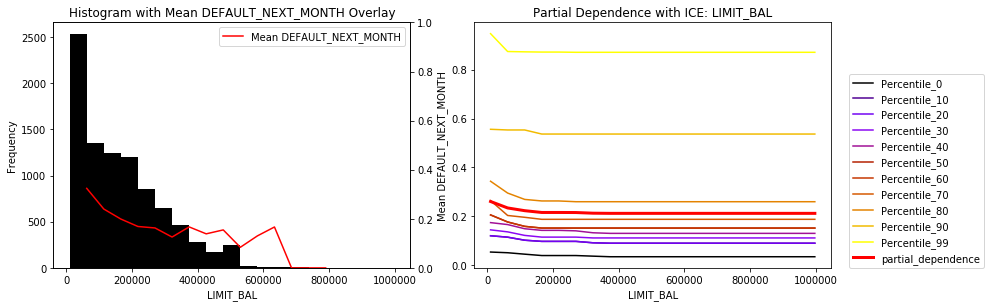

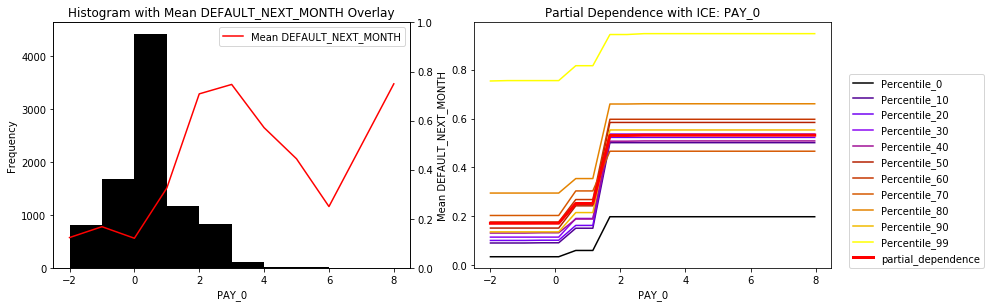

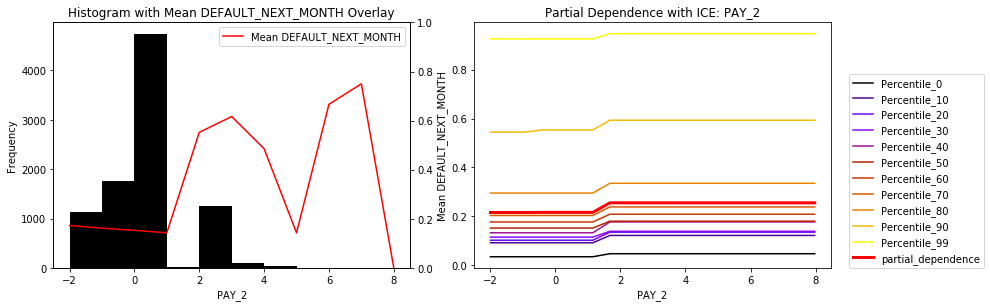

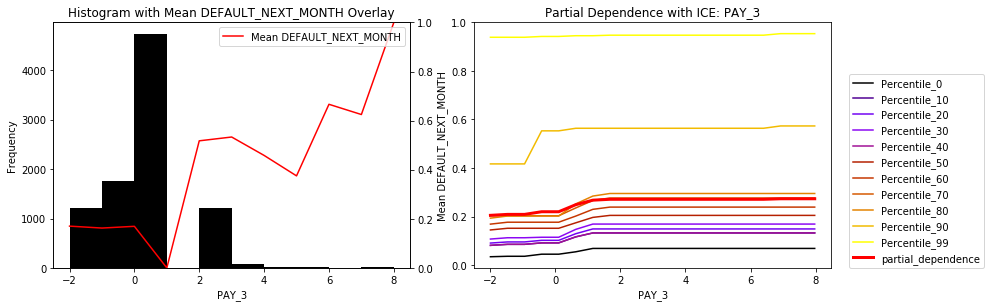

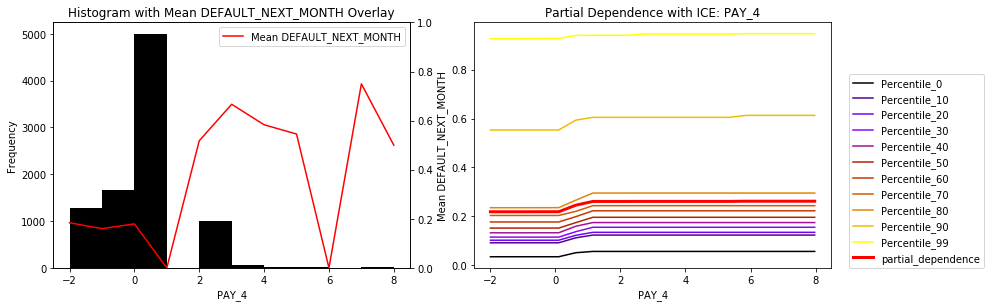

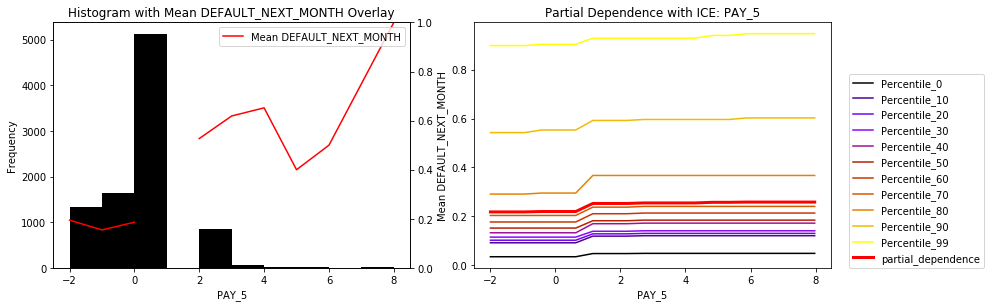

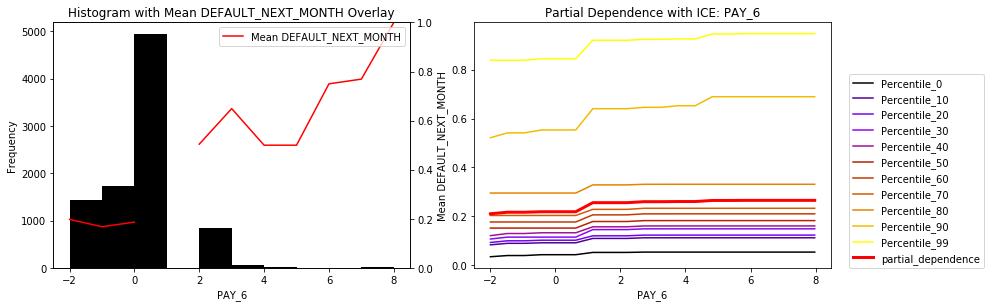

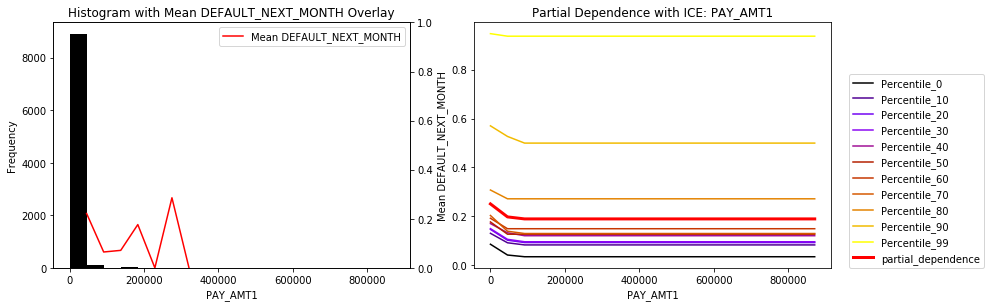

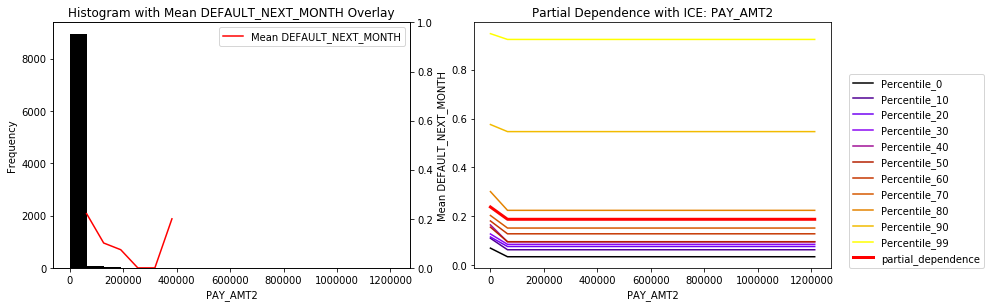

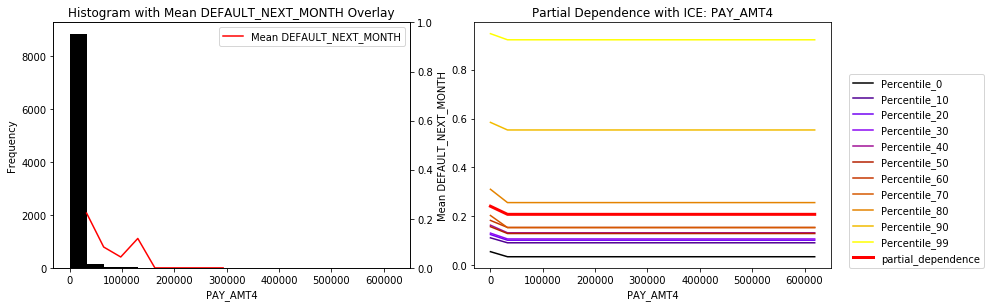

In [27]:
for xs in mgbm_selected: 
    explain.hist_mean_pd_ice_plot(xs, y_name, valid, mgbm_pd_ice_dict)

#### Save model

In [29]:
best_mgbm.model_id = 'best_mgbm'
h2o.save_model(best_mgbm, force=True)

'/home/patrickh/Workspace/GWU_rml/best_mgbm'

#### End global timer

In [30]:
big_toc = time.time() - big_tic
print('All tasks completed in %.2f s.' % (big_toc))

All tasks completed in 2799.92 s.


#### Shutdown H2O

In [31]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://localhost:54321 (Y/N)? y
H2O session _sid_9eb9 closed.
